In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from pycaret.regression import *

In [2]:
def smape(a, b):
    s = pd.Series(2*abs(a-b)/(abs(a)+abs(b))).fillna(0)
    return 100*s.sum()/len(s)

In [3]:
proteins = pd.read_csv('../data/train_proteins.csv')
peptides = pd.read_csv('../data/train_peptides.csv')
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)


In [4]:
npx_features = pd.pivot(proteins, index='visit_id',
                        values='NPX', columns='UniProt')


In [5]:
npx_features = npx_features.fillna(0)


<Axes: xlabel='UniProt', ylabel='UniProt'>

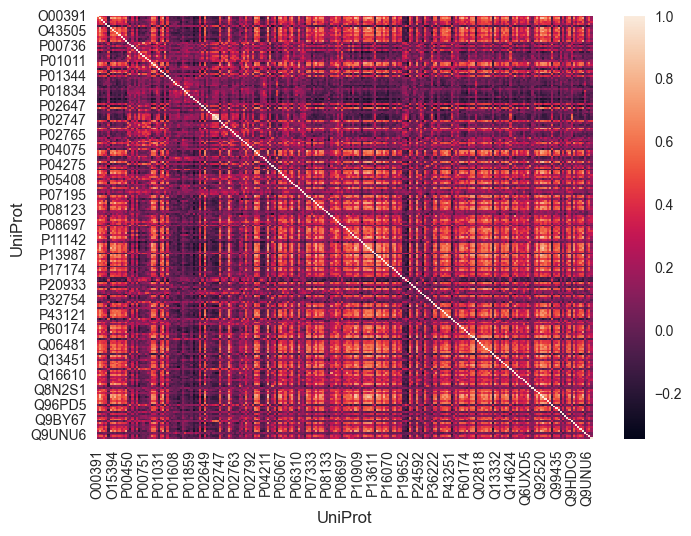

In [6]:
sns.heatmap(npx_features.corr())


In [7]:
clinical_data.head()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,6,NaN,NaN
55_3,55,3,10.0,7.0,19,NaN,NaN
55_6,55,6,8.0,10.0,58,NaN,NaN
55_9,55,9,8.0,9.0,17,0.0,On
55_12,55,12,10.0,10.0,2,0.0,On


In [8]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else:
        li.append(clinical_data.index.values[idx-1])

def offset_updrs2(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_2']

def offset_updrs1(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_1']

def offset_updrs3(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_3']

def offset_updrs4(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_4']

clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(
    offset_updrs2, axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(
    offset_updrs1, axis=1)
clinical_data['offset_updrs3_offset'] = clinical_data.apply(
    offset_updrs3, axis=1)
clinical_data['offset_updrs4_offset'] = clinical_data.apply(
    offset_updrs4, axis=1)





clinical_data.fillna(0, inplace=True)


In [9]:
clinical_data = clinical_data[[
    'updrs_1', 'updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset','offset_updrs3_offset','offset_updrs4_offset', 'updrs_3', 'updrs_4', 'visit_month']]


In [10]:
clinical_data

,updrs_1,updrs_2,offset_updrs2_offset,offset_updrs1_offset,offset_updrs3_offset,offset_updrs4_offset,updrs_3,updrs_4,visit_month
visit_id,,,,,,,,,
55_0,10.0,6.0,0.0,0.0,0,0.0,6,0.0,0
55_3,10.0,7.0,6.0,10.0,6,0.0,19,0.0,3
55_6,8.0,10.0,7.0,10.0,19,0.0,58,0.0,6
55_9,8.0,9.0,10.0,8.0,58,0.0,17,0.0,9
55_12,10.0,10.0,9.0,8.0,17,0.0,2,0.0,12
...,...,...,...,...,...,...,...,...,...
65043_48,7.0,6.0,10.0,9.0,4,0.0,51,0.0,48
65043_54,4.0,8.0,6.0,7.0,51,0.0,55,1.0,54
65043_60,6.0,6.0,8.0,4.0,55,1.0,0,1.0,60


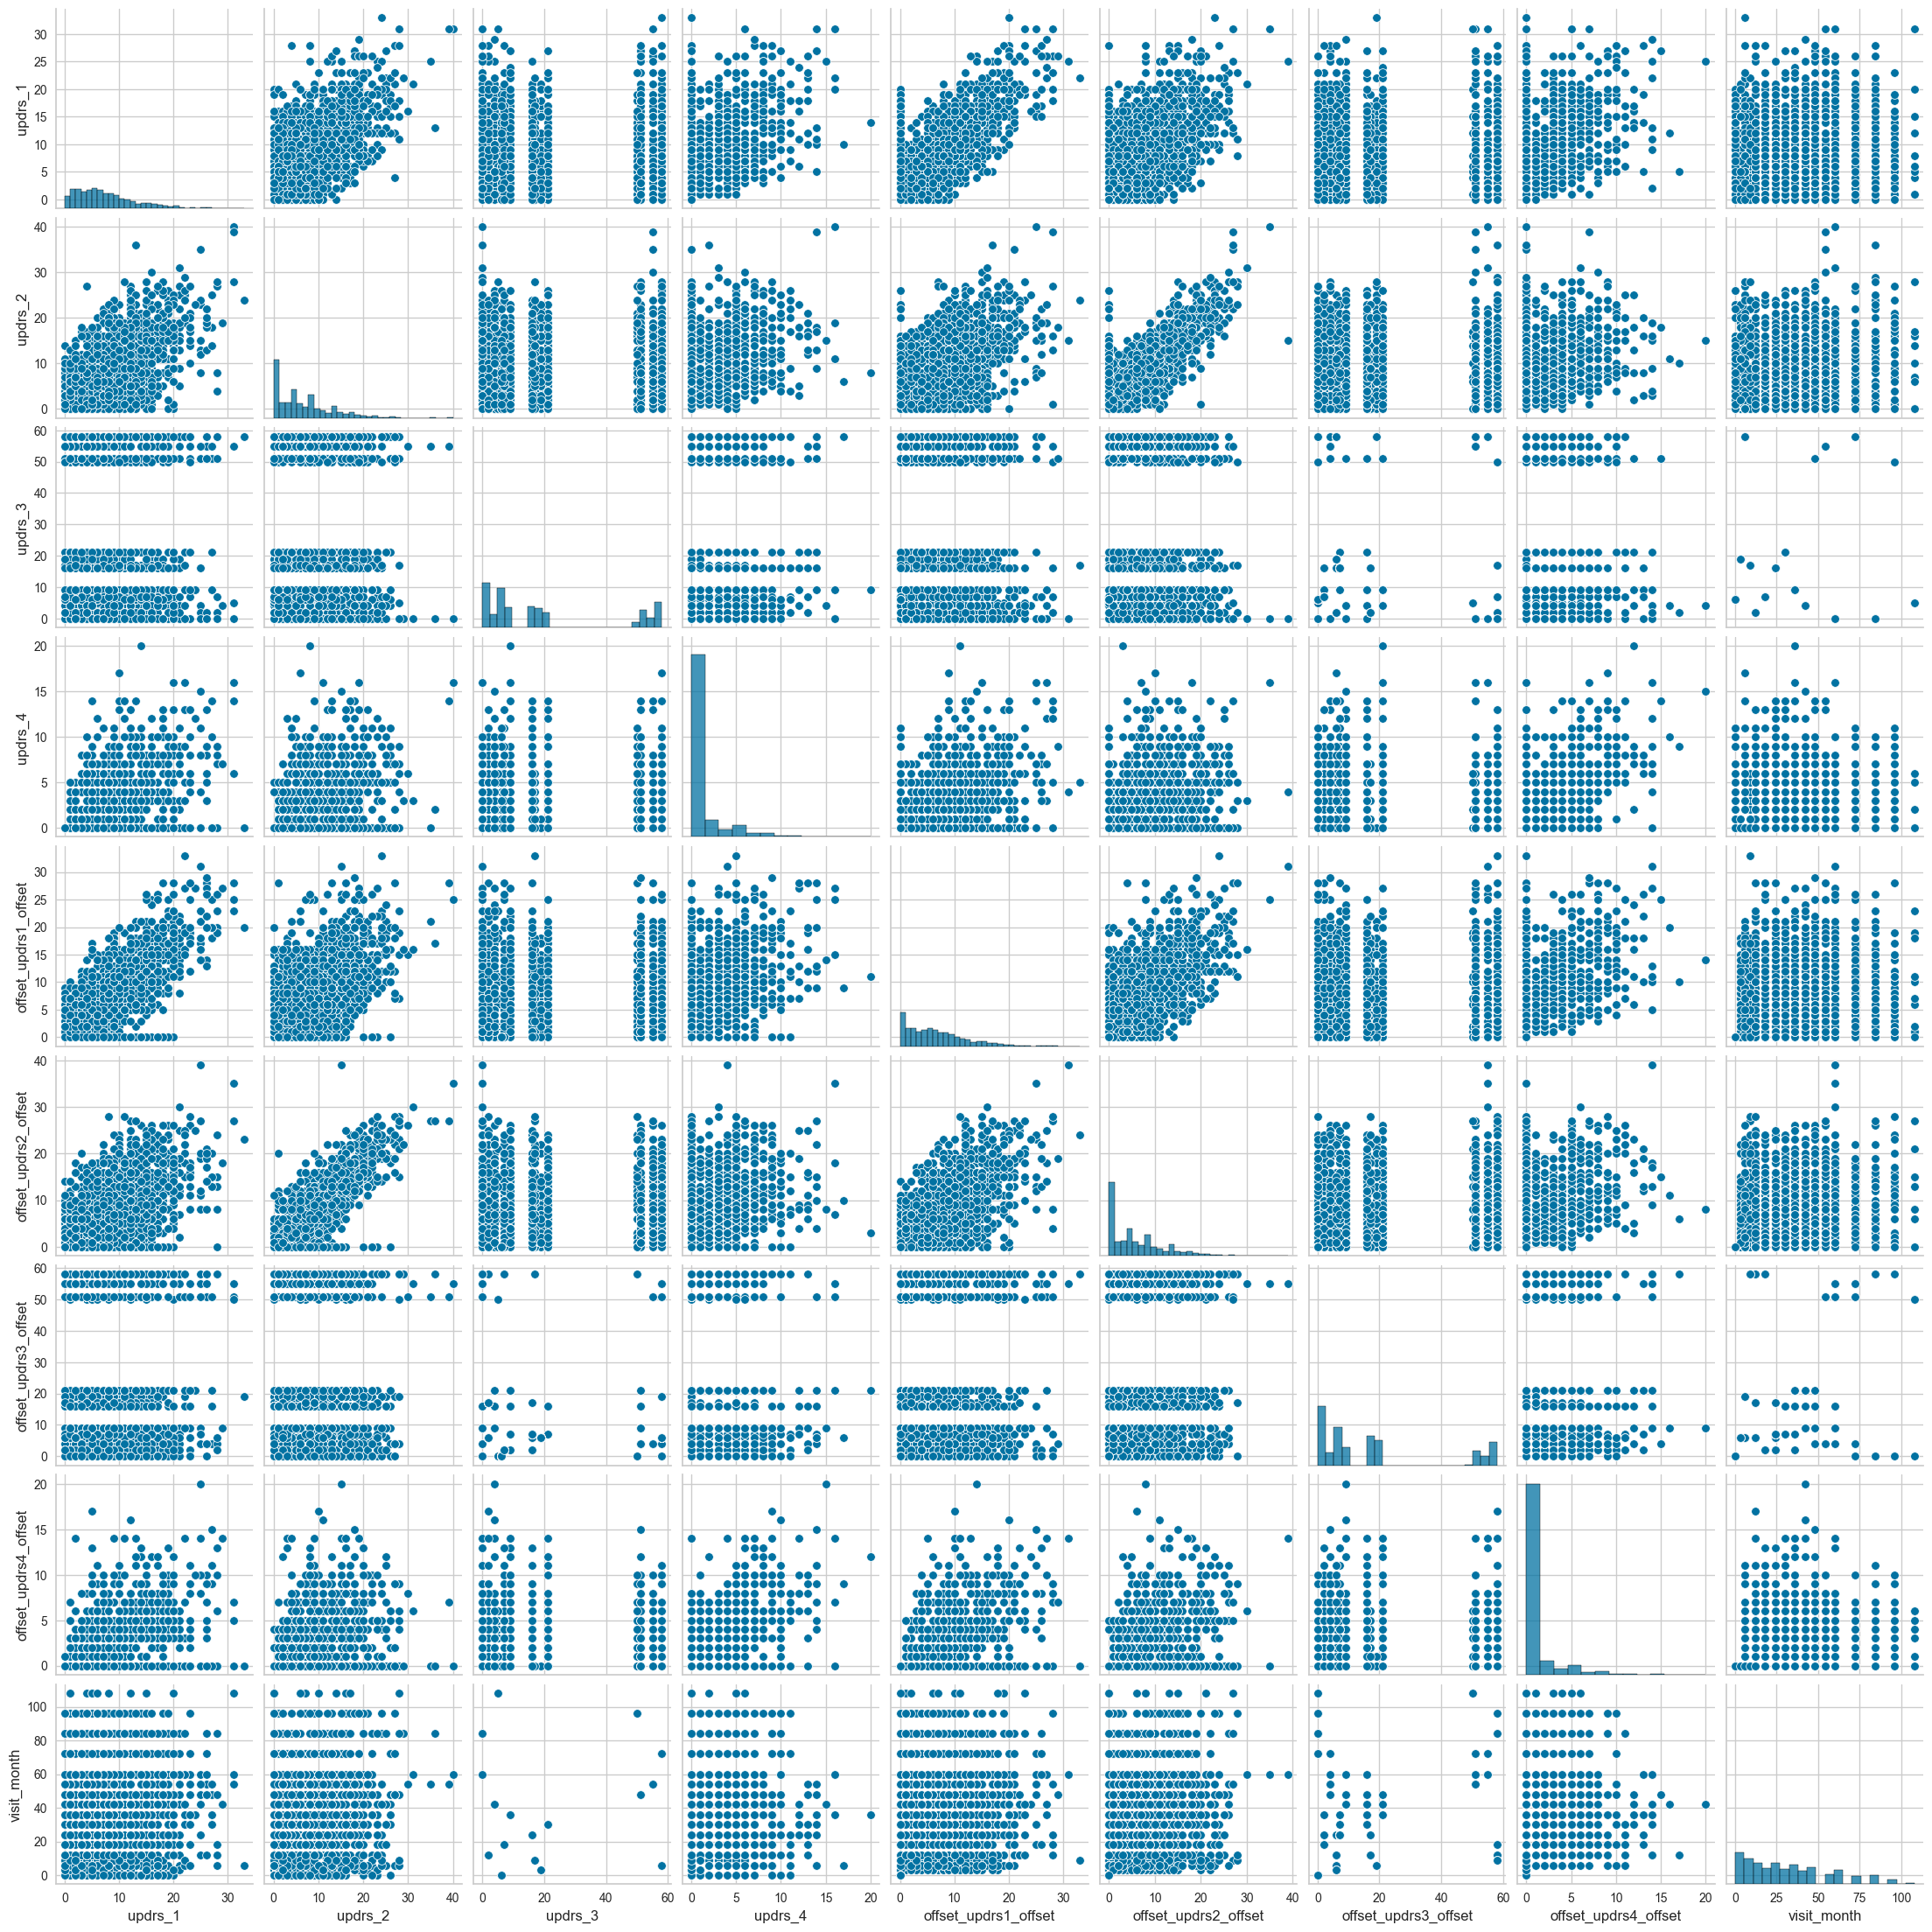

In [11]:
sns.pairplot(clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
             'offset_updrs1_offset', 'offset_updrs2_offset', 'offset_updrs3_offset', 'offset_updrs4_offset','visit_month']])


# UPDRS 1 Predictions with just protein data

In [12]:
dataset = pd.merge(clinical_data[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
best_model = compare_models(sort='R2')
tuned_model = tune_model(best_model, choose_better=True, optimize='SMAPE')
ensemble_u1 = ensemble_models(tuned_model, choose_better= True, n_estimators=20)



,Description,Value
0,Session id,3812
1,Target,target
2,Target type,Regression
3,Original data shape,"(1068, 233)"
4,Transformed data shape,"(1068, 233)"
5,Transformed train set shape,"(747, 233)"
6,Transformed test set shape,"(321, 233)"
7,Numeric features,232
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,2.5377,11.4923,3.3760,0.5693,0.5883,0.6616,52.0615,1.1220
rf,Random Forest Regressor,2.6181,12.1434,3.4718,0.5448,0.6003,0.6727,53.2382,2.6950
lightgbm,Light Gradient Boosting Machine,2.6497,12.4215,3.5121,0.5385,0.5992,0.6691,53.8471,1.1620
gbr,Gradient Boosting Regressor,2.6454,12.4422,3.5110,0.5355,0.5905,0.6534,53.1066,1.8840
en,Elastic Net,2.6259,12.4788,3.5194,0.5341,0.6116,0.6738,54.2521,0.7460
lasso,Lasso Regression,2.6302,12.4916,3.5218,0.5337,0.6130,0.6781,54.3350,0.7430
llar,Lasso Least Angle Regression,2.6302,12.4916,3.5218,0.5337,0.6130,0.6781,54.3351,0.8400
br,Bayesian Ridge,2.6245,12.4616,3.5138,0.5328,0.6047,0.6600,54.4297,0.9050
omp,Orthogonal Matching Pursuit,2.7021,13.0646,3.5937,0.5058,0.6127,0.6632,56.2319,0.9750
ada,AdaBoost Regressor,2.9270,13.6313,3.6781,0.4897,0.6710,0.8537,57.3575,0.9680


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.5714,13.0767,3.6162,0.6551,0.5582,0.5303,48.9669
1,2.3957,10.6818,3.2683,0.6607,0.5065,0.6420,49.2554
2,2.4940,11.3363,3.3669,0.5349,0.4934,0.5947,47.6301
3,2.4858,11.1814,3.3439,0.5502,0.5189,0.6201,45.3023
4,2.8391,12.6127,3.5514,0.3705,0.6582,0.8226,66.0414
5,2.8263,16.3492,4.0434,0.5840,0.5700,0.5276,51.7904
6,2.2140,8.3001,2.8810,0.6452,0.6352,0.5532,61.7938
7,2.2187,9.3319,3.0548,0.6414,0.5970,0.5175,48.9212
8,2.5014,11.6149,3.4081,0.4612,0.6558,0.5538,55.7359


Fitting 10 folds for each of 10 candidates, totalling 100 fits


NameError: name 'ensemble_models' is not defined

# UPDRS 2 Predictions with just Protein Data

In [ ]:
dataset = pd.merge(clinical_data[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
best_model = compare_models(sort='R2')
tuned_model = tune_model(best_model, choose_better=True, optimize='SMAPE')
ensemble_u2 = ensemble_models(tuned_model, choose_better= True, n_estimators=20)



# UPDRS 3 Predictions with Proteins Data

In [ ]:
dataset = pd.merge(clinical_data[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
best_model = compare_models(sort='R2')
tuned_model = tune_model(best_model, choose_better=True, optimize='SMAPE')
ensemble_u3 = ensemble_models(tuned_model, choose_better= True, n_estimators=20)



# UPDRS 4 Predictions with Proteins Data

In [ ]:
dataset = pd.merge(clinical_data[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
best_model = compare_models(sort='R2')
tuned_model = tune_model(best_model, choose_better=True, optimize='SMAPE')
ensemble_u4 = ensemble_models(tuned_model, choose_better= True, n_estimators=20)

